## Load libs

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log2, floor
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision
from torchvision import transforms
from torchvision.models import densenet121
from torch.distributions.multivariate_normal import MultivariateNormal

## Define dataset and model

In [2]:
def make_transform():
    """
    Make data transform.
    """
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(40),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

class RecursionDataset(data_utils.Dataset):
    def __init__(self,
                 train=True,
                 img_dir="/kaggle/input/recursion-simple",
                 transform=make_transform()):

        self.mode = "train" if train else "test"
        self.img_dir = img_dir
        self.transform = transform

        df = pd.read_csv(os.path.join(img_dir, f"new_{self.mode}.csv"))
        self.records = df.to_records(index=False)
        
    def __getitem__(self, index):
        img_path = os.path.join(
            self.img_dir, self.mode, self.mode, self.records[index].filename)
        img = Image.open(img_path)
        img = self.transform(img)
        sirna = int(self.records[index].sirna) if self.mode == "train" else -1
        sirna = torch.tensor(sirna)
        return (img, sirna)

    def __len__(self):
        return len(self.records)


In [3]:
class DCGAN(nn.Module):
    """Deep Convolutional Generative Adversarial Network"""

    def __init__(self,
                 num_latents=100,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,):
        """
        Initializes DCGAN.

        Args:
            num_latents: Number of latent factors.
            num_features: Number of features in the convolutions.
            image_channels: Number of channels in the input image.
            image_size: Size (i.e. height or width) of image.
            gan_type: Type of GAN (e.g. "gan" or "wgan-gp").
        """
        super().__init__()

        self.num_latents = num_latents
        self.num_features = num_features
        self.image_channels = image_channels
        self.image_size = image_size
        self.gan_type = gan_type
        self.fully_convolutional = fully_convolutional
        self.activation = activation
        self.use_batchnorm = use_batchnorm
        self.use_spectralnorm = use_spectralnorm

        D_params = {
            "num_latents": 1,  # XXX
            "num_features": num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm,
        }
        G_params = {
            "num_latents": num_latents,
            "num_features": num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm,
        }

        self.D = DCGAN_Discriminator(**D_params)
        self.G = DCGAN_Generator(**G_params)


class DCGAN_DiscriminatorBlock(nn.Module):
    """
    A discriminator convolutional block.
    Default stride and padding half the size of features,
    e.g. if input is [in_channels, 64, 64], output will be [out_channels, 32, 32].
    """

    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.conv = nn.utils.spectral_norm(self.conv)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.LeakyReLU(0.2, inplace=True) if activation is None else activation()

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class DCGAN_GeneratorBlock(nn.Module):
    """
    A generator convolutional block.
    Default stride and padding double the size of features,
    e.g. if input is [in_channels, 32, 32], output will be [out_channels, 64, 64].
    """

    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                                        stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.convT = nn.utils.spectral_norm(self.convT)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.LeakyReLU(0.2, inplace=True) if activation is None else activation() # XXX: ReLU?

    def forward(self, x):
        x = self.convT(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class DCGAN_Discriminator(nn.Module):
    """The discriminator of a DCGAN"""

    def __init__(self,
                 num_latents=1,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 D_block=DCGAN_DiscriminatorBlock):
        super().__init__()

        using_grad_penalty = gan_type in ("gan-gp", "wgan-gp")
        output_sigmoid = gan_type in ("gan", "gan-gp")

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm and not using_grad_penalty,
            "use_spectralnorm": use_spectralnorm,
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(num_features * 2**i, max_features) for i in range(num_layers)]

        # Input layer
        self.input_layer = D_block(image_channels, features[0], **block_config)

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            D_block(in_features, out_features, **block_config)
            for in_features, out_features in zip(features, features[1:])
        ])

        # Output layer (feature_size = 3, 4, or 5 -> 1)
        if fully_convolutional:
            self.output_layer = nn.Sequential(
                nn.Conv2d(features[-1], num_latents, latent_kernel, bias=False),
                View(-1),
            )
        else:
            self.output_layer = nn.Sequential(
                View(-1),
                nn.Linear(features[-1] * latent_kernel**2, num_latents, bias=False)
            )

        # Add sigmoid activation if using regular GAN loss
        self.output_activation = nn.Sigmoid() if output_sigmoid else None

    def forward(self, x):
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        if self.output_activation:
            x = self.output_activation(x)
        # Remove H and W dimensions, infer channels dim (remove if 1)
        x = x.view(x.size(0), -1).squeeze(1)
        return x


class DCGAN_Generator(nn.Module):
    """The generator of a DCGAN"""

    def __init__(self,
                 num_latents=100,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 G_block=DCGAN_GeneratorBlock):
        super().__init__()

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(num_features * 2**i, max_features) for i in range(num_layers)]

        # Reverse order of image sizes and features for generator
        image_sizes = image_sizes[::-1]
        features = features[::-1]

        # Input layer
        if fully_convolutional:
            self.input_layer = G_block(num_latents, features[0], kernel_size=latent_kernel,
                                       stride=1, padding=0, **block_config)
        else:
            self.input_layer = nn.Sequential(
                View(-1),
                nn.Linear(num_latents, features[0] * image_sizes[0]**2, bias=False),
                View(features[0], image_sizes[0], image_sizes[0])
            )

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            G_block(in_features, out_features, kernel_size=4+(expected_size%2), **block_config)
            for in_features, out_features, expected_size in zip(features, features[1:], image_sizes[1:])
        ])

        # Output layer
        self.output_layer = nn.ConvTranspose2d(features[-1], image_channels, kernel_size=4+(image_size%2),
                                               stride=2, padding=1, bias=False)
        self.output_activation = nn.Tanh()

    def forward(self, x):
        # Add H and W dimensions, infer channels dim (add if none)
        x = x.view(x.size(0), -1, 1, 1)
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x


class View(nn.Module):
    def __init__(self, *shape, including_batch=False):
        super().__init__()
        self.shape = shape
        self.including_batch = including_batch
    
    def forward(self, x):
        if self.including_batch:
            return x.view(*self.shape)
        else:
            return x.view(x.size(0), *self.shape)


In [4]:
class RAE(nn.Module):
    """
    Regularized Auto-encoders.
    """
    def __init__(self, encoder=None, decoder=None, noise_std=0.01, *args, **kwargs):
        super().__init__()
        self.encoder = DCGAN_Discriminator(gan_type="wgan-gp", *args, **kwargs) if encoder is None else encoder
        self.decoder = DCGAN_Generator(*args, **kwargs) if decoder is None else decoder
        self.noise_std = noise_std
    
    def sample_latent(self, x):
        device = x.device
        with torch.no_grad():
            z = self.encoder(x)
        # Just in case
        z = z.view(z.size(0), -1)
        batch_size, num_latents = z.size()
        # The covariance of z.t()
        mu = z.mean(dim=0, keepdim=True)
        z -= mu # normalize
        z_cov = z.t() @ z / (batch_size-1)  # (num_latents, num_latents)
        z_cov += 1e-5 * torch.eye(num_latents).to(z)  # to avoid singular matrix
        sampler = MultivariateNormal(mu.cpu().squeeze(), z_cov.cpu())
        samples = torch.stack([sampler.sample() for _ in range(batch_size)])
        return samples.to(device)

    def reconstruct(self, z):
        with torch.no_grad():
            x_re = self.decoder(z)
        return x_re
    
    def sample(self, x):
        z = self.sample_latent(x)
        x_re = self.reconstruct(z)
        return x_re, z
    
    def forward(self, x, noise_std=None):
        noise_std = self.noise_std if noise_std is None else noise_std
        z = self.encoder(x)
        z = z + torch.randn_like(z) * noise_std
        x_re = self.decoder(z)
        return x_re, z

In [5]:
def make_transform():
    """
    Make data transform.
    """
    # Original image size is 400x400
    return transforms.Compose([
        #transforms.RandomCrop(300),
        transforms.Resize(100),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

class RecursionDataset(data_utils.Dataset):
    def __init__(self,
                 train=True,
                 img_dir="/kaggle/input/recursion-simple",
                 transform=make_transform()):

        self.mode = "train" if train else "test"
        self.img_dir = img_dir
        self.transform = transform

        df = pd.read_csv(os.path.join(img_dir, f"new_{self.mode}.csv"))
        self.records = df.to_records(index=False)
        
    def __getitem__(self, index):
        img_path = os.path.join(
            self.img_dir, self.mode, self.mode, self.records[index].filename)
        img = Image.open(img_path)
        img = self.transform(img)
        sirna = int(self.records[index].sirna) if self.mode == "train" else -1
        sirna = torch.tensor(sirna)
        return (img, sirna)

    def __len__(self):
        return len(self.records)


In [14]:
### MNIST ###
image_size = 100  # original 400x400
image_channels = 3

### Hyperparameters ###
num_classes = 1108
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128
num_workers = 32
num_latents = num_classes*2
num_features = 64
num_epochs = 30
report_interval = 200
use_spectralnorm = False
use_gradnorm = True
z_sparsity = True
optimizer = torch.optim.Adam
lr = 1e-4

In [15]:
train_dataset = RecursionDataset(train=True)
test_dataset  = RecursionDataset(train=False)
trainloader = data_utils.DataLoader(train_dataset, batch_size=batch_size,
                                     shuffle=True, num_workers=num_workers)
testloader = data_utils.DataLoader(test_dataset, batch_size=batch_size,
                                    shuffle=False, num_workers=num_workers)

In [16]:
# Dataset, model, optimizer
rae = RAE(image_channels=image_channels, image_size=image_size,
          num_latents=num_latents, num_features=num_features)
optim = optimizer(rae.parameters(), lr=lr)

In [17]:
# Losses
def reconstruction_loss(x, y):
    return 0.5 * (x - y).pow(2).flatten(start_dim=1).sum(dim=1).mean()
    #return F.mse_loss(x, y)

def rae_loss(z):
    return 0.5 * z.pow(2).flatten(start_dim=1).sum(dim=1).mean()
    #return F.mse_loss(z, torch.zeros_like(z))

def grad_norm(x_re, z):
    grad = torch.autograd.grad(x_re, z, torch.ones_like(x_re), retain_graph=True)
    grad_norm = grad[0].flatten(start_dim=1).norm(dim=1)
    return grad_norm

def gradnorm_penalty(x_re, z):
    return grad_norm(x_re, z).mean()

def num_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("Number of parameters =", num_parameters(rae))

Number of parameters = 34620288


In [18]:
losses = []
reconstructions = []

In [29]:
%%time
### Train ###
rae.train()
rae = rae.to(device)
fixed_x, _ = next(iter(testloader))
fixed_x = fixed_x.to(device)

for epoch in range(num_epochs):
    for iters, data in enumerate(trainloader):
        optim.zero_grad()
        x, y = data
        x, y = x.to(device), y.to(device)
        x_re, z = rae(x)

        loss = reconstruction_loss(x_re, x)
        if use_gradnorm:
            loss += 0.02 * gradnorm_penalty(x_re, z)
        if z_sparsity:
            loss += z.abs().sum(dim=-1).mean()
        loss += rae_loss(z)
        loss.backward()
        optim.step()

        if (iters+1) % report_interval == 0:
            progress = f"[{epoch+1}/{num_epochs}][{iters+1}/{len(trainloader)}]"
            loss_stats = f"Loss = {loss.item():.4f}"
            print(progress, loss_stats)
            with torch.no_grad():
                fixed_x_re, _ = rae(fixed_x)
                reconstruction = torch.cat([fixed_x, fixed_x_re], dim=0).detach().cpu()
            reconstructions.append(reconstruction)
            losses.append(loss.item())

[1/30][200/571] Loss = 531.7855
[1/30][400/571] Loss = 533.3434
[2/30][200/571] Loss = 532.3095
[2/30][400/571] Loss = 515.6949
[3/30][200/571] Loss = 514.9658
[3/30][400/571] Loss = 522.5621
[4/30][200/571] Loss = 527.6740
[4/30][400/571] Loss = 532.0760
[5/30][200/571] Loss = 564.5505
[5/30][400/571] Loss = 528.8520
[6/30][200/571] Loss = 485.4262
[6/30][400/571] Loss = 458.4448
[7/30][200/571] Loss = 491.3983
[7/30][400/571] Loss = 495.2855
[8/30][200/571] Loss = 517.3979
[8/30][400/571] Loss = 443.4744
[9/30][200/571] Loss = 458.4284
[9/30][400/571] Loss = 502.5031
[10/30][200/571] Loss = 514.7091
[10/30][400/571] Loss = 487.0041
[11/30][200/571] Loss = 456.6429
[11/30][400/571] Loss = 539.2950
[12/30][200/571] Loss = 559.8035
[12/30][400/571] Loss = 488.7819
[13/30][200/571] Loss = 468.5434
[13/30][400/571] Loss = 447.3040
[14/30][200/571] Loss = 465.2619
[14/30][400/571] Loss = 523.1511
[15/30][200/571] Loss = 504.4491
[15/30][400/571] Loss = 485.9827
[16/30][200/571] Loss = 474.

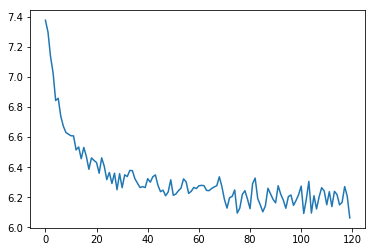

In [30]:
# Using log scale to examine convergence
_ = plt.plot(np.log(np.array(losses)))

In [31]:
class LatentClassifier(nn.Module):
    def __init__(self, in_features=num_latents, out_features=num_classes, hidden_features=256, n_hidden=0):
        super().__init__()
        hidden_layers = []
        for _ in range(n_hidden):
            hidden_layers += [nn.Linear(hidden_features, hidden_features), nn.LeakyReLU(0.2)]
        self.main = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            *hidden_layers,
            nn.Linear(hidden_features, out_features)
        )

    def forward(self, x):
        return self.main(x)

In [32]:
trainloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

n_hidden = 8
hidden_features = 512
classifier = LatentClassifier(in_features=num_latents, out_features=num_classes,
                              hidden_features=num_classes, n_hidden=n_hidden)
classifier_optim = torch.optim.Adam(classifier.parameters())
classifier_loss = nn.CrossEntropyLoss()
num_parameters(classifier)

13515384

In [33]:
def topk_accuracy(pred_y, y, k=3):
    topk_accuracies = [0] * (k+1)
    with torch.no_grad():
        topk = torch.topk(pred_y, k=k)
        for kk in range(1, k+1):
            hits = torch.zeros(pred_y.size(0)).byte()
            for k_i in range(kk):
                hits |= topk.indices[:, k_i].int() == y.int()
            topk_accuracies[kk] = hits.float().mean().item()
        return topk_accuracies

In [34]:
%%time
### Train ###
classifier.train()
classifier = classifier.to(device)
classifier_losses = []
for epoch in range(num_epochs):
    for iters, data in enumerate(trainloader):
        classifier_optim.zero_grad()
        x, y = data
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            z = rae.encoder(x)
        y_pred = classifier(z)

        loss = classifier_loss(y_pred, y)
        loss.backward()
        classifier_optim.step()

        if (iters+1) % report_interval == 0:
            progress = f"[{epoch+1}/{num_epochs}][{iters+1}/{len(trainloader)}]"
            loss_stats = f"Loss = {loss.item():.4f}"
            hits = (y_pred.argmax(dim=1) == y).sum()
            accuracy_stats = f"Accuracy = {hits.float() / y.size(0) * 100 :.2f}%"
            print(f"{progress} {loss_stats}, {accuracy_stats}")
            classifier_losses.append(loss.item())

            accuracies = topk_accuracy(y_pred.cpu(), y.cpu(), k=10)
            [print(f"- {k+1}: {100*acc:.2f}%") for k, acc in enumerate(accuracies[1:])]

[1/30][200/571] Loss = 7.0213, Accuracy = 0.00%
- 1: 0.00%
- 2: 0.00%
- 3: 0.00%
- 4: 0.00%
- 5: 0.00%
- 6: 0.00%
- 7: 0.00%
- 8: 0.00%
- 9: 0.00%
- 10: 0.00%
[1/30][400/571] Loss = 7.0058, Accuracy = 0.78%
- 1: 0.78%
- 2: 1.56%
- 3: 1.56%
- 4: 1.56%
- 5: 1.56%
- 6: 1.56%
- 7: 1.56%
- 8: 1.56%
- 9: 1.56%
- 10: 1.56%
[2/30][200/571] Loss = 7.0097, Accuracy = 0.78%
- 1: 0.78%
- 2: 0.78%
- 3: 0.78%
- 4: 2.34%
- 5: 2.34%
- 6: 2.34%
- 7: 2.34%
- 8: 2.34%
- 9: 2.34%
- 10: 2.34%
[2/30][400/571] Loss = 7.1116, Accuracy = 0.00%
- 1: 0.00%
- 2: 0.00%
- 3: 0.00%
- 4: 0.00%
- 5: 0.00%
- 6: 0.00%
- 7: 0.00%
- 8: 0.78%
- 9: 0.78%
- 10: 0.78%
[3/30][200/571] Loss = 7.0149, Accuracy = 0.00%
- 1: 0.00%
- 2: 0.78%
- 3: 0.78%
- 4: 0.78%
- 5: 0.78%
- 6: 0.78%
- 7: 0.78%
- 8: 1.56%
- 9: 1.56%
- 10: 1.56%
[3/30][400/571] Loss = 7.0342, Accuracy = 0.00%
- 1: 0.00%
- 2: 0.00%
- 3: 0.00%
- 4: 0.00%
- 5: 0.00%
- 6: 0.00%
- 7: 0.00%
- 8: 0.00%
- 9: 0.00%
- 10: 0.00%
[4/30][200/571] Loss = 7.0123, Accuracy = 0.00

[26/30][400/571] Loss = 5.6246, Accuracy = 2.34%
- 1: 2.34%
- 2: 3.12%
- 3: 3.91%
- 4: 6.25%
- 5: 7.81%
- 6: 10.16%
- 7: 10.94%
- 8: 12.50%
- 9: 16.41%
- 10: 17.19%
[27/30][200/571] Loss = 5.5623, Accuracy = 4.69%
- 1: 4.69%
- 2: 6.25%
- 3: 6.25%
- 4: 7.81%
- 5: 7.81%
- 6: 8.59%
- 7: 9.38%
- 8: 10.16%
- 9: 10.94%
- 10: 12.50%
[27/30][400/571] Loss = 5.4955, Accuracy = 0.78%
- 1: 0.78%
- 2: 3.12%
- 3: 3.91%
- 4: 7.03%
- 5: 12.50%
- 6: 13.28%
- 7: 14.84%
- 8: 15.62%
- 9: 19.53%
- 10: 21.88%
[28/30][200/571] Loss = 5.5221, Accuracy = 3.12%
- 1: 3.12%
- 2: 4.69%
- 3: 7.03%
- 4: 8.59%
- 5: 10.94%
- 6: 13.28%
- 7: 14.06%
- 8: 16.41%
- 9: 18.75%
- 10: 19.53%
[28/30][400/571] Loss = 5.3312, Accuracy = 3.12%
- 1: 3.12%
- 2: 4.69%
- 3: 7.81%
- 4: 10.16%
- 5: 11.72%
- 6: 14.06%
- 7: 15.62%
- 8: 16.41%
- 9: 18.75%
- 10: 20.31%
[29/30][200/571] Loss = 5.3728, Accuracy = 2.34%
- 1: 2.34%
- 2: 3.12%
- 3: 4.69%
- 4: 6.25%
- 5: 9.38%
- 6: 10.94%
- 7: 12.50%
- 8: 14.06%
- 9: 14.84%
- 10: 15.62%
[29/30][

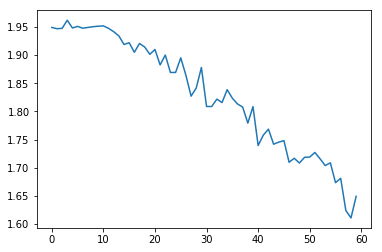

In [35]:
# Using log scale to examine convergence
_ = plt.plot(np.log(np.array(classifier_losses)))